# Importing Packages & Loading Data

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings 
warnings.filterwarnings("ignore")

In [68]:
df = pd.read_csv('workout_data.csv', parse_dates=['timestamp'])
df.head()

,timestamp,fitness_discipline,title,duration,instructor,calories,distance,avg_hr
0,2021-08-02 18:03:24+00:00,running,30 min J Balvin Run,1800,Robin Arzón,315,3.28,169
1,2021-08-01 15:44:11+00:00,running,45 min Endurance Run,2700,Becs Gentry,420,4.92,172
2,2021-07-30 17:12:49+00:00,running,30 min Tropical House Run,1800,Selena Samuela,334,3.28,173
3,2021-07-29 13:21:49+00:00,running,30 min Intervals Run,1800,Becs Gentry,346,3.39,174
4,2021-07-22 18:59:52+00:00,running,20 min Intervals Run,1200,Chase Tucker,61,0.66,150


# Data Cleaning & Wrangling

In [69]:
# convert duration from seconds to minutes
df['duration'] = df['duration'].apply(lambda x: x // 60)

In [70]:
# creating new datetime-based features
df['timestamp'] = df['timestamp'].apply(lambda x: pd.to_datetime(x).tz_convert('US/Eastern'))
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.day_name()
df['week_num'] = df['timestamp'].apply(lambda x: x.isocalendar()[1])

In [71]:
# get weekday_num in order of MTWTFSS because we want to sort the rows of the heatmap in order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {k: v for k, v in zip(weekday_order, [i+1 for i in range(7)])}
df['weekday_num'] = df['weekday'].apply(lambda x: mapping[x])

In [72]:
# let's also save a variable of month abbreviations for tick labeling purposes later
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']

In [73]:
# filter out 'Just Run' because only interested in Peloton on-demand classes
df = df[~df.title.str.contains('Just Run')]

# strip the first part of the titles, which indicates the duration (e.g. '45 min ...')
run_titles = list(df['title'])
run_titles = [x[7:] if int(x[:2]) else x for x in run_titles]

# inspect the unique types of runs in the dataset
print(set(run_titles))

{'HIIT & Hills Run', 'EDM Run', 'Endurance Run', 'Long Run Warm Up', 'HIIT Run', 'Intervals Run', 'House Run', 'Pop Run', 'Pop Punk Run', 'Breakthrough Run', 'Progression Run', 'Rock Run', 'Tempo Run', 'Beyoncé Run', 'Tropical House Run', 'J Balvin Run', 'Hip Hop Run'}


In [74]:
# devise a mapping strategy to partition runs into categories
def get_run_type(x):
    types = ['Endurance', 'Intervals', 'HIIT & Hills', 'HIIT', 'Warm Up', 'Cool Down', 'Tempo', 'Progression']
    for run_type in types:
        if run_type in x:
            return run_type
        
    # there are many runs based on musical genre (Beyonce, J Balvin, Hip Hop, EDM, ...)
    # designate these runs as 'Music' runs
    # serves as a catch-all if no specific training category applies
    return "Music"

df['run_type'] = df['title'].apply(lambda x: get_run_type(x))

In [75]:
# filter dataset to only look at running workouts in 2021
data_2021 = df[(df['year'] == 2021) & (df['fitness_discipline'] == 'running')]
data_2021

,timestamp,fitness_discipline,title,duration,instructor,calories,distance,avg_hr,year,month,hour,weekday,week_num,weekday_num,run_type
0,2021-08-02 14:03:24-04:00,running,30 min J Balvin Run,30,Robin Arzón,315,3.28,169,2021,8,14,Monday,31,1,Music
1,2021-08-01 11:44:11-04:00,running,45 min Endurance Run,45,Becs Gentry,420,4.92,172,2021,8,11,Sunday,30,7,Endurance
2,2021-07-30 13:12:49-04:00,running,30 min Tropical House Run,30,Selena Samuela,334,3.28,173,2021,7,13,Friday,30,5,Music
3,2021-07-29 09:21:49-04:00,running,30 min Intervals Run,30,Becs Gentry,346,3.39,174,2021,7,9,Thursday,30,4,Intervals
4,2021-07-22 14:59:52-04:00,running,20 min Intervals Run,20,Chase Tucker,61,0.66,150,2021,7,14,Thursday,29,4,Intervals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2021-02-12 14:24:54-05:00,running,20 min Beyoncé Run,20,Robin Arzón,183,2.05,67,2021,2,14,Friday,6,5,Music
78,2021-02-06 11:20:28-05:00,running,30 min Pop Run,30,Jess Sims,565,3.22,168,2021,2,11,Saturday,5,6,Music
79,2021-02-03 12:25:54-05:00,running,20 min Intervals Run,20,Olivia Amato,165,1.33,130,2021,2,12,Wednesday,5,3,Intervals
80,2021-02-03 11:59:34-05:00,running,20 min HIIT Run,20,Adrian Williams,185,1.67,150,2021,2,11,Wednesday,5,3,HIIT


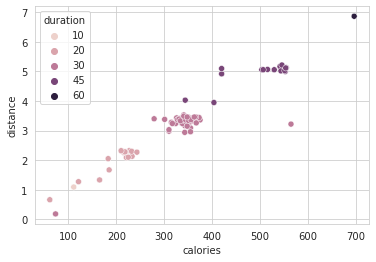

In [76]:
sns.scatterplot(data=data_2021, x='calories', y='distance', hue='duration');

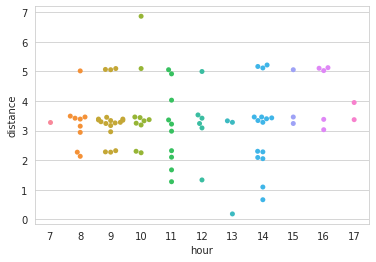

In [77]:
sns.swarmplot(data=data_2021, x='hour', y='distance');

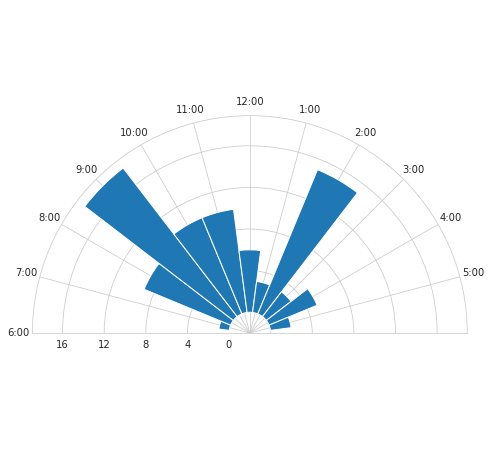

In [154]:
sns.set_style('whitegrid')
arr = list(df['hour'])
N = 12
bottom = 2

# create theta for 12 hours
theta = np.linspace(0.0, np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
_, tick = np.histogram(arr, bins = N)
radii = df['hour'].value_counts().sort_index().reindex([i+1 for i in range(5, 5+N)]).fillna(0)

# width of each bin on the plot
width = (np.pi) / N

# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# set the lable go clockwise and start from the left-hand side (West)
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1) # clockwise

# we just want half of the polar chart
ax.set_thetamin(0)
ax.set_thetamax(180)


# setting xticks and xticklabels
ax.set_xticks(np.pi/180 * np.linspace(0, 180, N, endpoint=False))
ticks = [str(x % 12) + ":00" if x != 12 else "12:00" for x in radii.index]
ax.set_xticklabels(ticks);
ax.set_rgrids([4*i + 2 for i in range(5)], labels=[str(x-2) for x in [4*i + 2 for i in range(5)]])

plt.show()

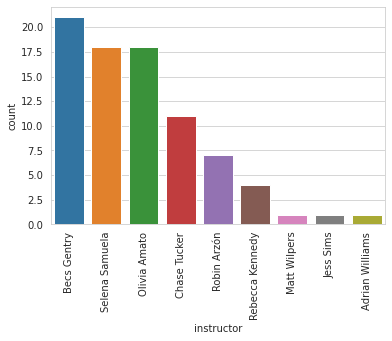

In [7]:
ax = sns.countplot(data=data_2021, x='instructor', 
                   order=data_2021['instructor'].value_counts().index);
plt.xticks(rotation=90);
plt.show()

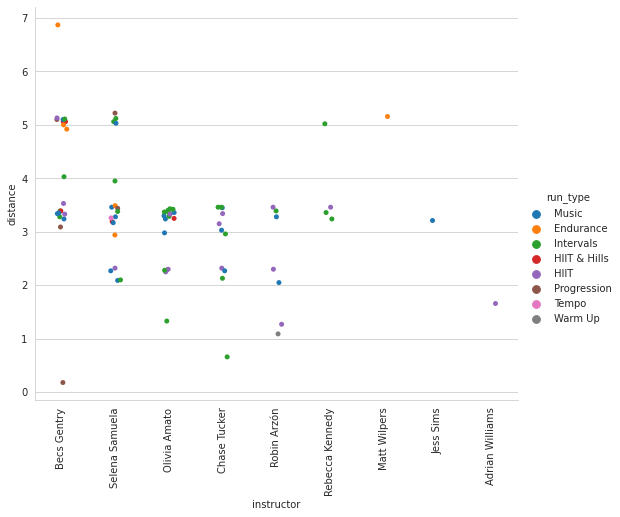

In [8]:
ax = sns.catplot(data=data_2021, x='instructor', y='distance', hue='run_type', 
                   order=data_2021['instructor'].value_counts().index, height=6, aspect=1.2);
plt.xticks(rotation=90);
plt.show()

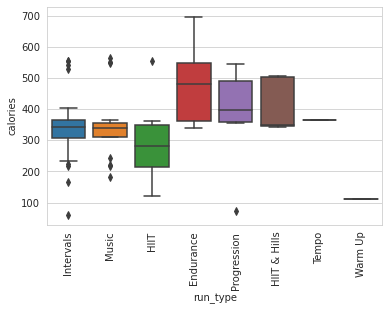

In [9]:
ax = sns.boxplot(data=data_2021, x='run_type', y='calories',
                   order=data_2021['run_type'].value_counts().index);
plt.xticks(rotation=90);
plt.show()

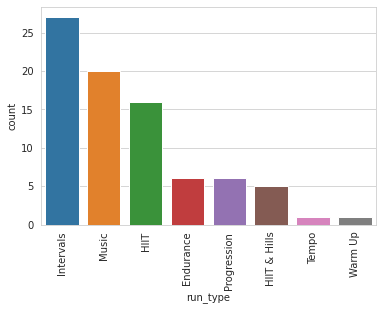

In [10]:
ax = sns.countplot(data=data_2021, x='run_type', 
                   order=data_2021['run_type'].value_counts().index);
plt.xticks(rotation=90);
plt.show()

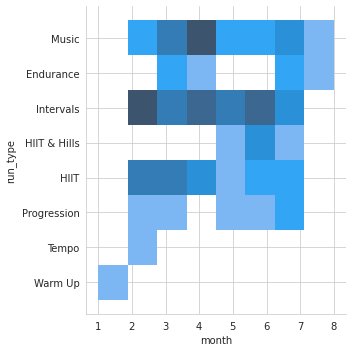

In [11]:
sns.displot(data=data_2021, x='month', y='run_type');

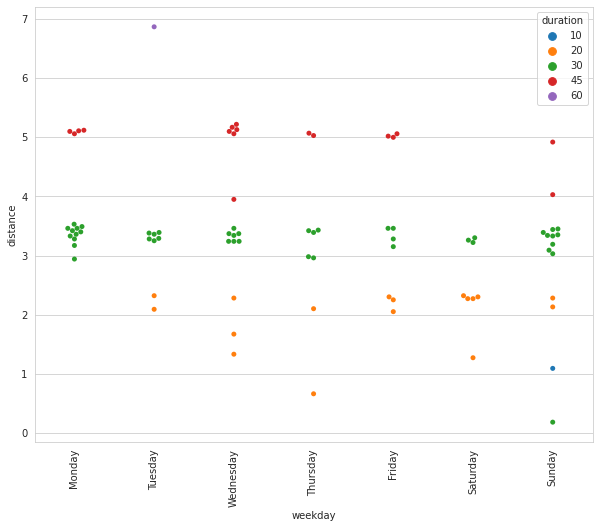

In [12]:
fig = plt.figure(figsize=(10,8));
ax = sns.swarmplot(data=data_2021, x='weekday', y='distance', order=weekday_order, 
                   hue='duration');
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax;

<AxesSubplot:xlabel='timestamp'>

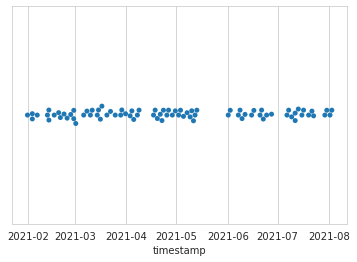

In [13]:
sns.swarmplot(x=data_2021['timestamp'])

In [14]:
df_to_pivot = data_2021[['week_num', 'weekday_num', 'distance']]
pivoted_data = pd.pivot_table(df_to_pivot, values='distance', index=['weekday_num'], columns=['week_num'], aggfunc=np.mean)
pivoted_data = pivoted_data.reindex([i+1 for i in range(max(pivoted_data.columns))], axis=1)
pivoted_data

week_num,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
weekday_num,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.12,3.46,2.94,...,NaN,3.17,NaN,3.42,NaN,NaN,NaN,5.06,NaN,3.28
2,NaN,NaN,NaN,NaN,NaN,NaN,3.38,NaN,NaN,NaN,...,3.29,3.28,3.39,2.32,NaN,2.090,6.87,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1.50,NaN,NaN,3.46,NaN,3.37,...,3.24,2.28,3.37,NaN,NaN,3.240,NaN,5.17,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.42,...,NaN,NaN,NaN,5.07,NaN,NaN,3.43,0.66,3.39,NaN
5,NaN,NaN,NaN,NaN,NaN,2.050,3.15,3.46,NaN,NaN,...,NaN,5.06,NaN,NaN,NaN,2.250,2.30,NaN,3.28,NaN
6,NaN,NaN,NaN,NaN,3.22,1.795,3.26,NaN,2.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.09,NaN,NaN,NaN,2.86,NaN,3.34,...,NaN,NaN,3.19,2.13,NaN,1.635,NaN,NaN,4.92,NaN


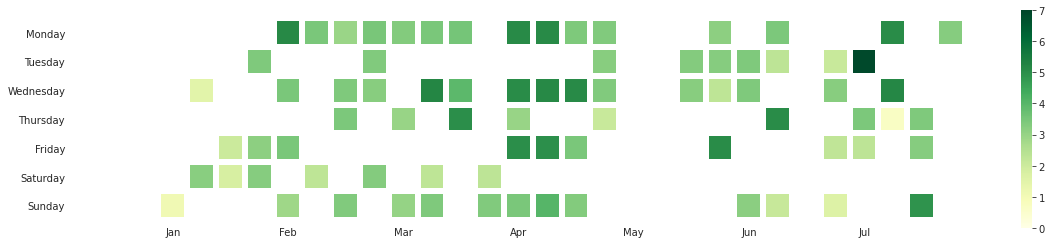

In [15]:
plt.figure(figsize=(20,4));
space = [" ", " ", " "]
sns.heatmap(pivoted_data, linewidths=6, vmin=0, vmax=7, cmap='YlGn', cbar=True,
                 linecolor='white', square=True, yticklabels=weekday_order, 
            xticklabels=[*space, 'Jan', *space, 'Feb', *space, 'Mar', *space, 'Apr', 
                         *space, 'May', *space, 'Jun', *space, 'Jul']);
plt.ylabel("");
plt.xlabel("");

In [66]:
fig, ax = plt.subplots(1,2);
sns.countplot(data=data_2021, x='weekday', order=weekday_order, color='teal', ax=ax[0]);
sns.countplot(data=data_2021, x='month', color='purple', order=month_order
                   order=[i+1 for i in range(max(data_2021['month']))], ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90);
plt.show()

SyntaxError: invalid syntax (43928459.py, line 4)

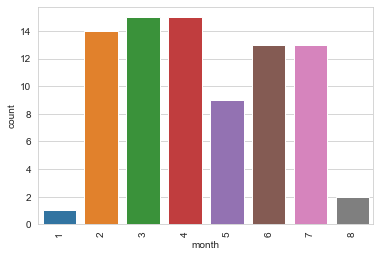

In [13]:

plt.xticks(rotation=90);
plt.show()

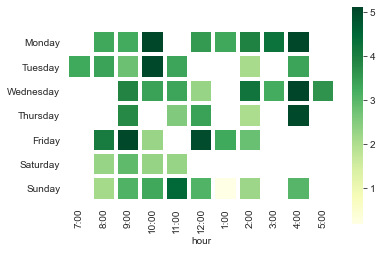

In [194]:
df_pivoted = pd.pivot_table(data_2021[['weekday_num', 'hour', 'distance']], 
                           values='distance', index=['weekday_num'], 
                           columns=['hour'], aggfunc=np.mean)
sns.heatmap(df_pivoted, cmap='YlGn', yticklabels=weekday_order, square=True, linewidths=3,
            xticklabels = [str(x % 12) + ":00" if x != 12 else "12:00" for x in df_pivoted.columns]);
plt.ylabel("");


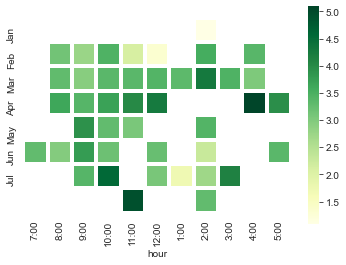

In [193]:
df_pivoted = pd.pivot_table(data_2021[['month', 'hour', 'distance']], 
                           values='distance', index=['month'], 
                           columns=['hour'], aggfunc=np.mean)
sns.heatmap(df_pivoted, cmap='YlGn', square=True, linewidths=3,
            yticklabels=month_order, 
            xticklabels = [str(x % 12) + ":00" if x != 12 else "12:00" for x in df_pivoted.columns]);
plt.ylabel("");